# E-commerce — Выявление профилей потребления

## Описание проекта  

Интернет-магазин товаров для дома «Пока все ещё тут» в срочном порядке ищет аналитиков. Мы поможем нашему магазину стать лучше, а клиентам — обустроить дом своей мечты. Наши ближайшие задачи — выявление профилей покупателей, а также их сегментация и анализ.
«Пока все ещё тут» — мы создаём уют!

## Материалы:  
(https://disk.yandex.ru/i/K_S3lMNQqdlqZQ)

## Цель проекта  

Выявление профилей потребления, для заказчика — рекламного отдела итернет магазина «Пока все ещё тут»  
С целью помочь заказчику создать рекламную рассылку

## Задачи  

* Сегментировать покупателей по профилю потребления, т.е. составить подробные рекомендации заказчику по кластерам пользователей. 
* Определить клиентам какого кластера, когда и какие категории товара рассылать в рекламных предложениях. 
* Определить как и для какого кластера можно попытаться увеличить количество продаваемого товара, повысить возвращаемость покупателей и т.д.

## Описание данных  

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».

Колонки в  *ecommerce_dataset.csv* :

* `date` — дата заказа;
* `customer_id` — идентификатор покупателя;
* `order_id` — идентификатор заказа;
* `product` — наименование товара;
* `quantity` — количество товара в заказе;
* `price` — цена товара.

## Гипотезы  

 **1.** Помочь с распределением пользователей по кластерам могут данные о количестве заказов пользователя и колчичестве чеков, таким образом можно будет определить пользователей с `высокой` потребительской активностью, `средней` и `низкой` соответственно.  Кроме того таким образом можно будет определить возвращающихся пользователей.  
 
 **2.** Приобретаемые товары клиентами интернет магазина «Пока все ещё тут» могут быть хорошим маркером, знание какие товары пользуются наибольшим спросом у каждой из 3-х категорий может помочь с таргетингом рекламы для пользователей. Так заказчику будет удобнее определить какой товар предложить клиенту в e-mail рассылке.  

 **3.** Для каждого из 3-х кластеров пользователей возможно есть сезонные предпочтения к покупкам товаров, определим в какое время пользователи чаще всего покупают те или иные товары, это может помочь нам определить когда лучше присылать СМС, e-mail рассылки клиентам

## Порядок действий  

**1.** Обзор данных  

**1.1.** Предобработка данных  

**2.** Исследовательский анализ данных 

**2.1** Распределим пользователей по категориям, добавим столбец в котором установим пользователей с `высокой` потребительской активностью, `средней` и `низкой`, на основе количества заказов и чеков которые оставил один пользователь.  

**2.2.** Распределим пользователей по категориям при помощи добавления сегментации товаров, например добавим к определенным товарам категории: `рассада цветы`, `все для дома`, и.т.д.

**2.3.** Узнаем какие товары у каждой категории покупателей пользуются наибольшим спросом.  

**2.4.** Узнаем есть ли сезонность покупок для каждой из 3-х потребительских групп.  

**2.5.** Проверим отличается ли средний чек по каждой из 3-х потребительских групп, выявим есть ли между ними критический уровень статистической значимости, проведем A/B тест

**3.** Сформируем выводы.

## 1. Обзор данных 

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
from numpy import percentile
import math as mth
import matplotlib.pyplot as plt
from datetime import datetime as dt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
# from pymystem3 import Mystem
from nltk.stem import SnowballStemmer
import re

from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats as st

Для удобной работы с датафреймом настроим отображение всей ширины столбцов и зададим настройку игнорировать предупреждения

In [2]:
# Установим максимальное отображение столбцов
pd.set_option('display.max_columns', None)

# Установим отображение всей ширины стобца
pd.set_option('display.max_colwidth', None)

# Игнорируем предупреждения
pd.set_option('chained_assignment', None)

Обьявим переменную и сохраним в нее датафрейм

In [3]:
# Сохраним данные в переменную data
try: # яндексовский путь
    data = pd.read_csv('ecommerce_dataset.csv')
except: # мой путь
    data = pd.read_csv('D:\datasets\ecommerce_dataset.csv')

In [4]:
# Выведем первые пять строк датафрейма
display(data.head(10))

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
5,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0
6,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0
7,2018100108,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0
8,2018100108,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С614, 1404056",1,269.0
9,2018100109,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379,1,674.0


Видим что названия столбцов соотвествуют данным в таблице, названия колонок следуют "хорошему стилю"  буквы в нижнем регистре, пробелы заменены на `underscore` — *нижнее подчеркивание*, таким образом названия колонок следуют "змеиному стилю"

Посмотрим на типи данных и оценим общий объем информации в датафрейме

In [5]:
# Выведем информацию о датафреймах методом info()
display(data.info())

# Посмотрим есть ли в столбцах датафрейма пропуски методом isna() и подсчитаем их количество методом sum()
display('Пропусков в колонках таблицы:', data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


None

'Пропусков в колонках таблицы:'

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Видим что данные присутствуют во всех столбцах датафрейма, пропусков не обнаружено.  
Всего в датафрейме `6737` строк и `6` колонок.  
В колонке `date` — хранятся данные о датах совершения заказов и имеют тип `int64`, приведем его к типу `datetime` на следующем этапе.

## 1.1. Предобработка данных

Для начала переведем формат данных в столбце `date` к формату `datetime`  
На этапе обзора данных мы видели что данные о времени заказа в датафрейме хранятся в формате `int64` и включают в себя год/месяц/день/час покупки, всего `10` чисел. По этому зададим формат даты до часа покупки.

In [6]:
# Воспользуемся методом to_datetime библиотеки pandas
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')

Проведем проверку данных на дубликаты

In [7]:
# Проверим данные датафрейма на явные дубликаты методом duplicated()
print('Дубликатов в датафрейме:', data.duplicated().sum())

Дубликатов в датафрейме: 0


Добавим в датафрейм данные о общей цене заказа

In [8]:
data['month'] = data['date'].astype('datetime64[M]')

Проверим предобработку данных и выведем датафрейм на экран

In [9]:
display(data.head())

,date,customer_id,order_id,product,quantity,price,month
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018-10-01
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01


In [10]:
data.shape

(6737, 7)

In [11]:
data.drop(columns='date').drop_duplicates().shape

(4941, 6)

In [12]:
data.drop(columns='date',inplace=True)
data = data.drop_duplicates()

In [13]:
data.shape

(4941, 6)

In [14]:
some_orders = data.groupby('order_id').customer_id.nunique().sort_values()

In [15]:
data = data[~data['order_id'].isin(some_orders[some_orders>1].index)]

Что послужило причиной появления у одного заказа двух пользователей не ясно. ЛУчше их убрать, чтобы не было проблем далее. К тому же их не так уж и много

## 2. Исследовательский анализ данных

Посмотрим какие данные предложены в датафрейме, есть ли среди них выбросы, любые другие ошибки которые помешают нам в дальнейшей работе.  
Выведем на экран описание данных методом describe посмотрим на 25, 50, 75, 90, 97 и 99 персентили  

**Проведем исследование в столбце `quantity` - количество товара в заказе**

In [16]:
# Воспользуемся методом describe
display(data['quantity'].describe(percentiles=[.25, .5, .75, .9, .97, .99]).to_frame())

,quantity
count,4872.000000
mean,2.798030
std,17.572031
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
90%,3.000000
97%,11.000000
99%,30.000000


Видим что максимально кочичество товаров 1000 штук за раз, посмотрим что это за покупка

In [17]:
data[data['quantity']>30].sort_values('quantity').tail()

,customer_id,order_id,product,quantity,price,month
568,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0,2018-11-01
1158,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0,2018-12-01
3961,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0,2019-05-01
5071,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,2019-06-01
5456,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000",1000,675.0,2019-06-01


In [18]:
# Воспользуемся логической индексацией
data.loc[data['quantity']==1000]

,customer_id,order_id,product,quantity,price,month
5456,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000",1000,675.0,2019-06-01


**Вывод:**  
Такая покупка возможна, но судя по кол-ву остальных товаров, скорее всего это выброс. Предположительно, была произведена ошибка при внесении кол-ва товаров. В качестве решения проблемы предлагается заменить 1000 на 1

In [19]:
data.loc[5456,'quantity'] = 1

In [20]:
# Воспользуемся методом describe
display(data['quantity'].describe(percentiles=[.25, .5, .75, .9, .97, .99]).to_frame())

,quantity
count,4872.000000
mean,2.592980
std,10.226704
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
90%,3.000000
97%,10.870000
99%,30.000000


In [21]:
# Умножим количество позиций заказа на цену одной позиции
data['revenue'] = data['quantity'] * data['price']

**Проведем исследование данных в столбце `revenue` - выручка**

In [22]:
# Воспользуемся методом describe
display(data['revenue'].describe(percentiles=[.25, .5, .75, .9, .97, .99]).to_frame())

,revenue
count,4872.000000
mean,709.444376
std,1700.174128
min,9.000000
25%,120.000000
50%,191.000000
75%,734.000000
90%,1724.000000
97%,3711.090000
99%,6148.290000


**Посмотрим сколько всего товаров было приобретено** 

In [23]:
display(data.groupby('order_id').agg({'quantity': 'sum'}).describe(percentiles=[.25, .5, .75, .9, .97, .99]))

,quantity
count,2755.000000
mean,4.585481
std,14.792103
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
90%,10.000000
97%,25.000000
99%,52.840000


Построим гистограму распределения количества товаров в одной покупке, сгруппируем данные по `order_id` и посчитаем количество товаров при помощи функции

In [24]:
data['quantity'].sum()

12633

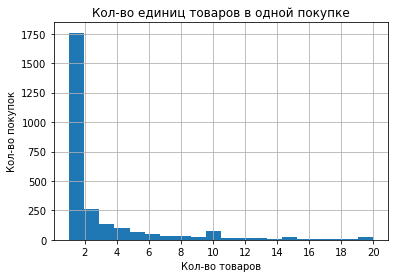

In [25]:
# Построим гистограму
data.groupby('order_id').agg({'quantity': 'sum'}).hist(range=(1, 20), bins=20)
plt.title('Кол-во единиц товаров в одной покупке')
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Кол-во товаров')
plt.ylabel('Кол-во покупок');

**Вывод:**   
Всего было продано `15854` товара 
В среднем покупателе совершают `6` покупок за раз. Медиана по кол-ву покупок равна `1`.
Из этого можно сделть вывод, что распределение скошено влево.

**Посмотрим как изменялось количество заказов по месяцам**

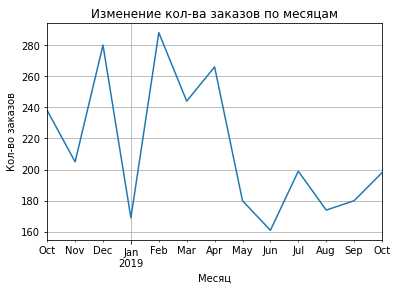

In [26]:
data.groupby(['month']).agg({'order_id': 'nunique'}).plot(grid=True, legend=False)
plt.title('Изменение кол-ва заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Кол-во заказов');

Видно, что есть снижение покупательской способности в январе. Скорее всего это связано с январскими праздниками, но есть вероятность, что за январь в выборке отсутствуют данные. 

## 2.1. Категоризация

Категоризируем данные датасета, для начала сгруппируем данные по `customer_id`  
* Посчитаем количество уникальных `order_id` пользователя;  
* Сумарную выручку с пользователя в `revenue`;  
* Суму заказаного товара в `quantity`

In [27]:
clients_cats = data.groupby('customer_id', as_index=False).agg({'order_id':'nunique','revenue':'sum','quantity':'sum'})

In [28]:
clients_cats.head(10) 

,customer_id,order_id,revenue,quantity
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,555.0,4
1,001cee7f-0b29-4716-b202-0042213ab038,1,442.0,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,914.0,2
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.0,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2324.0,2
5,004d24e9-4a6c-4d0e-8727-8391dfd4b43a,1,1536.0,12
6,005ba170-45e8-42de-93f7-192481ae2659,1,1199.0,1
7,00bd74b1-2792-47db-a2f1-680a09ac5026,1,937.0,1
8,00c0f92a-121a-4883-a78d-2c7b5fe187de,1,134.0,1
9,00cd704a-a65c-4865-b39a-779f1b4f1d1a,1,112.0,1


Добавим в датасет столбец `arpu` - *(Average revenue per user)*, средняя выручка на одного пользователя

In [29]:
clients_cats['arpu'] = clients_cats['revenue'] / clients_cats['order_id']

Логорифмируем данные 

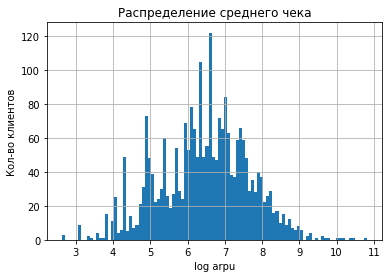

In [30]:
np.log(clients_cats['arpu']).hist(bins=100)
plt.title('Распределение среднего чека')
plt.xlabel('log arpu')
plt.ylabel('Кол-во клиентов');

In [31]:
clients_cats.describe(percentiles=[.25, .5, .75, .9, .95, .99])

,order_id,revenue,quantity,arpu
count,2394.000000,2394.000000,2394.000000,2394.000000
mean,1.150794,1443.781537,5.276942,1250.178274
std,2.686314,4322.918549,18.315289,2204.912372
min,1.000000,14.000000,1.000000,14.000000
25%,1.000000,300.000000,1.000000,298.000000
50%,1.000000,717.500000,1.000000,676.000000
75%,1.000000,1574.000000,3.000000,1480.875000
90%,1.000000,2927.400000,10.000000,2785.000000
95%,2.000000,4284.150000,20.000000,3974.000000
99%,3.000000,9201.690000,60.000000,7884.490000


**Вывод:**  
Выявлена аномалия - более `90%` пользователей совершили не более одного заказа. 
Рекомендуется обратиться к тем, кто прислал данную выборку для уточнения ситуации.

Отсортируем данные по столбцу `order_id` посмотрим на максимальное количество заказов которое мы выявили ранее: `126`

In [32]:
clients_cats.sort_values('order_id')

,customer_id,order_id,revenue,quantity,arpu
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,555.0,4,555.000000
1563,ab10dfb3-1f3e-4712-972a-729f5cec2eb2,1,553.0,2,553.000000
1565,ab46eafd-f9d3-4f91-af42-794d675d9c0c,1,157.0,1,157.000000
1566,ab938608-1b5b-4830-9fc0-dfc649c04b2f,1,177.0,3,177.000000
1567,abdc17c8-0813-4b05-9e10-1ffc77eea2d8,1,413.0,7,413.000000
...,...,...,...,...,...
16,0184f535-b60a-4914-a982-231e3f615206,5,5891.0,58,1178.200000
1706,b7b865ab-0735-407f-8d0c-31f74d2806cc,7,3779.0,68,539.857143
1074,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17,21361.0,17,1256.529412
727,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35,57278.0,309,1636.514286


In [33]:
data[data['customer_id']=='c971fb21-d54c-4134-938f-16b62ee86d3b']['product'].nunique()

130

Очень странный пользователь. Рекомендуется его исключить, т.к есть вероятность, что это ошибка в данных

In [34]:
data = data[data['customer_id']!='c971fb21-d54c-4134-938f-16b62ee86d3b']

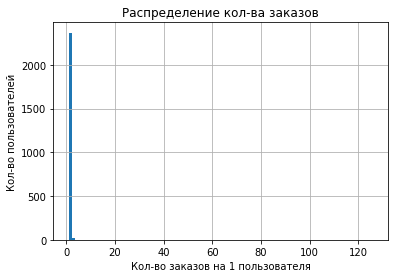

In [35]:
clients_cats['order_id'].hist(bins=100)
plt.title('Распределение кол-ва заказов')
plt.xlabel('Кол-во заказов на 1 пользователя')
plt.ylabel('Кол-во пользователей');

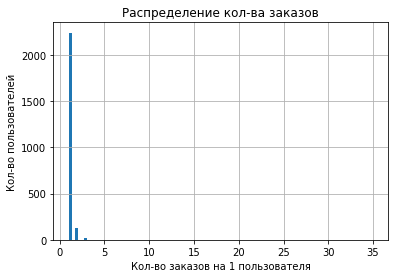

In [36]:
clients_cats[clients_cats['customer_id']!='c971fb21-d54c-4134-938f-16b62ee86d3b']['order_id'].hist(bins=100)
plt.title('Распределение кол-ва заказов')
plt.xlabel('Кол-во заказов на 1 пользователя')
plt.ylabel('Кол-во пользователей');

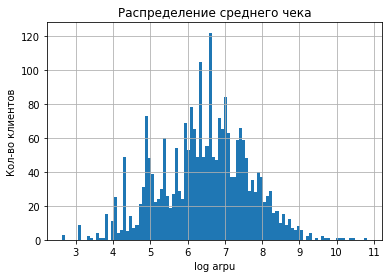

In [37]:
np.log(clients_cats[clients_cats['customer_id']!='c971fb21-d54c-4134-938f-16b62ee86d3b'].arpu).hist(bins=100)
plt.title('Распределение среднего чека')
plt.xlabel('log arpu')
plt.ylabel('Кол-во клиентов');

In [38]:
log_arpu = np.log(clients_cats[clients_cats['customer_id']!='c971fb21-d54c-4134-938f-16b62ee86d3b'].arpu)

In [39]:
log_arpu.describe(percentiles=[.05, .95])

count    2393.000000
mean        6.452826
std         1.190512
min         2.639057
5%          4.304065
50%         6.516193
95%         8.287528
max        10.808353
Name: arpu, dtype: float64

В качестве граничных значений будем использовать 90% доверительный интервал на основе персентелей

In [40]:
def price_segment(x):
    if x>8.48:
        return 'высокий'
    elif x >=4.3 and x<=8.48:
        return 'средний'
    else:
        return 'низкий'

In [41]:
clients_cats['price_segment'] = np.log(clients_cats['arpu']).apply(price_segment)

In [42]:
clients_cats.head(10)

,customer_id,order_id,revenue,quantity,arpu,price_segment
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,555.0,4,555.0,средний
1,001cee7f-0b29-4716-b202-0042213ab038,1,442.0,1,442.0,средний
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,914.0,2,914.0,средний
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.0,1,1649.0,средний
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2324.0,2,2324.0,средний
5,004d24e9-4a6c-4d0e-8727-8391dfd4b43a,1,1536.0,12,1536.0,средний
6,005ba170-45e8-42de-93f7-192481ae2659,1,1199.0,1,1199.0,средний
7,00bd74b1-2792-47db-a2f1-680a09ac5026,1,937.0,1,937.0,средний
8,00c0f92a-121a-4883-a78d-2c7b5fe187de,1,134.0,1,134.0,средний
9,00cd704a-a65c-4865-b39a-779f1b4f1d1a,1,112.0,1,112.0,средний


In [43]:
top_segments = (clients_cats['price_segment']
                .value_counts()
                .reset_index()
                .rename(columns={'index': 'price_segment', 
                                 'price_segment': 'count'})
                .sort_values(by='count', ascending = False))
top_segments

,price_segment,count
0,средний,2226
1,высокий,86
2,низкий,82


Text(0.5, 1.0, 'Количество пользователей в категории')

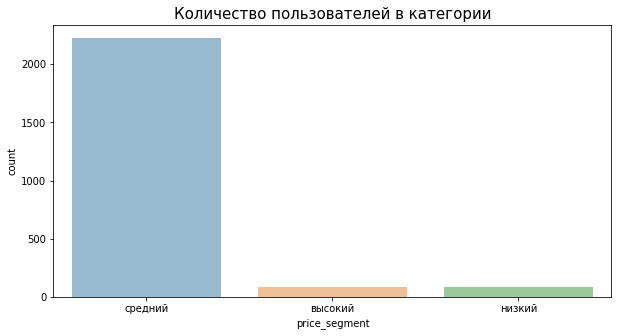

In [44]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='price_segment', y='count',
                 data=top_segments,
                 alpha=0.5)
ax.set_title('Количество пользователей в категории', fontsize=15)

## 2.2. Сегментация

In [45]:
data['product'].nunique()

2271

In [46]:
data[data['product'].apply(lambda x: True if 'нау' in x.lower() else False)]

,customer_id,order_id,product,quantity,price,month,revenue


In [47]:
data['price'].max()

14917.0

In [48]:
data[data['price']==14917]

,customer_id,order_id,product,quantity,price,month,revenue
5992,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400 40 м 175х237х237 см зеленая,1,14917.0,2019-07-01,14917.0


In [49]:
data.head()

,customer_id,order_id,product,quantity,price,month,revenue
0,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,142.0
1,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018-10-01,194.0
2,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,112.0
3,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,179.0
4,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,112.0


In [50]:
snowball = SnowballStemmer(language="russian")

In [51]:
data['prepare_text'] = data['product'].apply(lambda x: re.sub(r'[^а-я ]','',x.lower().replace('ё','е')))
data['prepare_text'] = data['product'].apply(lambda x: " ".join([snowball.stem(y) for y in x.split()]))

In [52]:
countvec = CountVectorizer(ngram_range=(1,2))

In [53]:
matrix = countvec.fit_transform(data['prepare_text'])

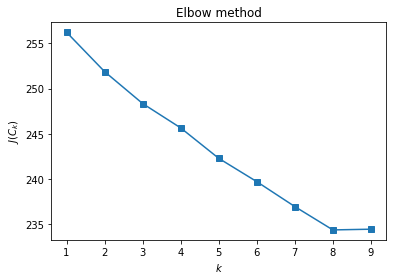

In [54]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(matrix)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 10), inertia, marker='s');
plt.title('Elbow method')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Оптимальное кол-во кластеров — 5

In [55]:
kmeans = KMeans(n_clusters=5, random_state=1).fit(matrix)

In [56]:
data['cluster'] = kmeans.labels_

In [57]:
top_items = data.groupby(['customer_id','cluster','product'],as_index=False).quantity.sum()

In [58]:
top_items[top_items['cluster']==0].sort_values('quantity',ascending=False)

,customer_id,cluster,product,quantity
1683,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,0,Муляж ЯБЛОКО 9 см красное,300
3020,aa42dc38-780f-4b50-9a65-83b6fa64e766,0,Муляж ЯБЛОКО 9 см красное,170
197,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,0,Муляж ЯБЛОКО 9 см красное,140
3973,de95510f-3558-4c42-97dc-98cc4215c278,0,"Универсальный нож WEBBER из нержавеющей стали Русские мотивы 12,7 см с деревянной ручкой ВЕ-2252D",80
1291,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,0,Салфетка Protec Textil Polyline 30х43 см Аметист белая 6230,60
...,...,...,...,...
1799,6242596a-92a2-4808-8257-63ae973cd4c4,0,"Покрытие для гладильной доски Dressfix XL 140х40 см на веревке жасмин, Leifheit, 72328",1
1790,61467178-1b59-4c2b-bba7-ced50d80e11f,0,"Одеяло Wellness 1410 пуховое белое, 100% белый пух 500 гр, 140х200 см, 4607101064199",1
1788,6103dd99-546e-4800-a283-1cd5fd7a3958,0,Доска разделочная Alparaisa стеклянная Завтрак 20х30 см RD0030-ST,1
1787,60dd35d2-27c8-4621-9378-4e4ad1677db9,0,Бальзамин новогвинейский d-13 см цвет фуксии,1


In [59]:
top_items[top_items['cluster']==1].sort_values('quantity',ascending=False)

,customer_id,cluster,product,quantity
3668,d2312fff-3f16-482f-8303-7f54680807f8,1,Пеларгония зональная диам. 12 см красная махровая,18
4362,f479df63-c15c-4d4e-9866-cd91b3e8bcfc,1,Пеларгония зональная диам. 12 см красная махровая,11
3377,bfa5c5ea-61c5-4cd8-b257-329981a70ea0,1,Пеларгония зональная диам. 12 см белая махровая,6
3354,bea7a833-2074-42db-bc49-4457abd3c930,1,Пеларгония зональная диам. 12 см сиреневый полумахровый,6
3379,bfa5c5ea-61c5-4cd8-b257-329981a70ea0,1,Пеларгония зональная диам. 12 см лососевая махровая,6
...,...,...,...,...
1801,62952c5b-e5ef-4009-a2f9-1ebff401c514,1,Пеларгония зональная диам. 12 см коралловая полумахровая,1
1802,62952c5b-e5ef-4009-a2f9-1ebff401c514,1,Пеларгония зональная диам. 12 см сиреневый полумахровый,1
1803,62952c5b-e5ef-4009-a2f9-1ebff401c514,1,Пеларгония зональная диам. 12 см темнорозовая полумахровая,1
1855,65750d7d-d0b4-46d1-83c2-f6756f0ab8a1,1,Пеларгония зональная диам. 12 см сиреневый полумахровый,1


In [60]:
top_items[top_items['cluster']==2].sort_values('quantity',ascending=False)

,customer_id,cluster,product,quantity
937,363f8d24-6d16-428f-8c89-a0fab51a5436,2,Сушилка для белья напольная НИКА СБ3Б 10 м белая,10
1304,49cf5289-122d-41ae-9672-d5943b007ca7,2,Сушилка для белья настенная Zalger Prima 510-720 веревочная 7 линий 25 м,4
2241,7c07ced3-b809-4a37-8650-e79f9f1a4ea5,2,"Прищепки для белья York Spring Prestige, 9603/Z027",2
237,0efde029-f588-4d48-9a62-a90597443d0f,2,Сушилка для белья потолочно-настенная Gimi Lift 200,2
2953,a5ab3199-f4dd-4992-90dd-a8e95e179a45,2,Сушилка для белья потолочная ЛИАНА ЛЮКС 170 см ЛЛП-170,2
...,...,...,...,...
1641,5a5a3e12-dd24-4580-9671-3ba5472817f1,2,"Сушилка для белья на стену Leifheit Telegant 100, белая, 83100",1
1643,5aa8dfc6-2ac3-4213-83dc-ad69667a3ce8,2,"Сушилка для белья потолочная Лиана 2,0 м 1703009",1
1648,5b3d4d1d-98a8-4e19-9010-0b3d26578782,2,Сушилка для белья Leifheit Siena 18 м 81151,1
1650,5b8356c0-5437-4b96-b69e-c196277b17d0,2,Сушилка для белья ЛИАНА ЛЮКС 130 см потолочная,1


In [61]:
top_items[top_items['cluster']==3].sort_values('quantity',ascending=False)

,customer_id,cluster,product,quantity
1407,4d93d3f6-8b24-403b-a74b-f5173e40d7db,3,"Герань домашняя (пеларгония зональная) цветущая D12, H25-30, коралловая, полумахровая",11
1483,4f75ae10-0ffb-4728-8885-3dadfa7204f7,3,Пеларгония розебудная Margaretha укорененный черенок,10
1196,42f16745-609a-44f9-9aec-aeedecd22d15,3,Пеларгония розебудная Red Pandora укорененный черенок,9
3380,bfa5c5ea-61c5-4cd8-b257-329981a70ea0,3,Пеларгония розебудная Rosebud Red d-7 см,6
1966,6c4cb43f-ae80-41aa-827d-0f569d7afbd7,3,Пеларгония розебудная Queen Ingrid укорененный черенок,5
...,...,...,...,...
1615,58a966e2-b773-4ddd-aeff-472f8320a6a3,3,Пеларгония розебудная Prins Nikolai укорененный черенок,1
1601,579034b8-ab03-4077-b8c7-7a5e0289e412,3,Пеларгония розебудная Prins Nikolai укорененный черенок,1
1542,54417722-4dc6-40b3-bc5a-f71fc905583e,3,Пеларгония Toscana Angeleyes Amarillo Rosato укорененный черенок,1
1541,54417722-4dc6-40b3-bc5a-f71fc905583e,3,Пеларгония Toscana Angeleyes Amarillo Burgundy укорененный черенок,1


In [62]:
top_items[top_items['cluster']==4].sort_values('quantity',ascending=False)

,customer_id,cluster,product,quantity
335,146cd9bf-a95c-4afb-915b-5f6684b17444,4,Вешалки мягкие для деликатных вещей 3 шт шоколад,334
3002,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,4,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200
3564,cd09ea73-d9ce-48c3-b4c5-018113735e80,4,"Крепеж для пружины дверной, 1107055",150
1902,685d3d84-aebb-485b-8e59-344b3df8b3d3,4,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150
3565,cd09ea73-d9ce-48c3-b4c5-018113735e80,4,"Пружина дверная 240 мм оцинкованная (Д-19 мм) без крепления, 1107014",150
...,...,...,...,...
1754,601b9c5d-b87b-47d9-95d0-269c734ad5b4,4,Тележка багажная DELTA ТБР-20 синий грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ,1
1752,5fe1274b-74ac-4a16-bde7-48e28879b2c6,4,"Мешок для деликатной стирки 50х70см, Attribute, ALB257",1
1750,5fa9bbd0-f5b2-47e6-ad5d-a38c6e69c9b2,4,"Многолетнее растение Тимьян-чабрец розовый объем 0,5 л",1
1747,5f7bbd5a-26dc-48ba-bcd8-19560f880fd3,4,"Ванна 70 л оцинкованная г.Магнитогорск, 1301016",1


Некоторые кластеры очень схожи друг с другом по наполению. Поэтому объединим их под общей категорий

График - пользовательская категория + товары. 

In [63]:
def segmentation(x):
    if x in [2,0]:
        return 'рассада'
    elif x==3:
        return 'комнатные цветы'
    elif x==4:
        return 'товары для дома'
    elif x==1:
        return 'цветы'

In [64]:
data['segment'] = data['cluster'].apply(segmentation)

In [65]:
data.segment.value_counts()

товары для дома    2271
рассада            1797
комнатные цветы     383
цветы               278
Name: segment, dtype: int64

In [66]:
data.head()

,customer_id,order_id,product,quantity,price,month,revenue,prepare_text,cluster,segment
0,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,142.0,"комнатн растен в горшк ал вера, d12, h30",4,товары для дома
1,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,2018-10-01,194.0,"комнатн растен в горшк коф арабика, d12, h25",4,товары для дома
2,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,112.0,радермахер d-12 см h-20 см,0,рассада
3,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,179.0,хризолидокарпус лутесценс d-9 см,0,рассада
4,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,112.0,циперус зумул d-12 см h-25 см,0,рассада


Проверим какова сезонность продаж товаров по категориям 

In [67]:
rev_catseason = data.groupby(['month', 'segment']).agg({'customer_id':'nunique',
                                                         'quantity': 'sum',
                                                         'revenue':'sum'})
rev_catseason.head()

customer_id  quantity   revenue
month      segment                                         
2018-10-01 комнатные цветы           12        36    5287.0
           рассада                   99       465  144013.0
           товары для дома          100       900  167875.0
           цветы                      7        33    5748.0
2018-11-01 комнатные цветы           12        36    5364.0

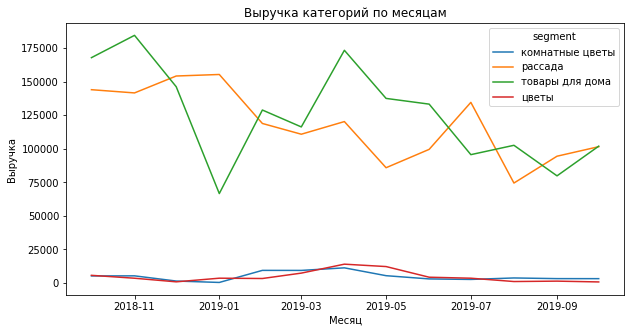

In [68]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='month', y='revenue', hue='segment', data = rev_catseason.reset_index())
plt.title('Выручка категорий по месяцам')
plt.ylabel('Выручка')
plt.xlabel('Месяц')
plt.show()

In [69]:
top_items.sort_values('quantity',ascending=False, inplace=True)

In [70]:
top_items['segment'] = top_items['cluster'].map(segmentation)

# 2.3. Топ-10 товарв в сегменте

In [71]:
top_items.groupby('segment').head(10).sort_values(['segment','quantity'], ascending=False)

,customer_id,cluster,product,quantity,segment
3668,d2312fff-3f16-482f-8303-7f54680807f8,1,Пеларгония зональная диам. 12 см красная махровая,18,цветы
4362,f479df63-c15c-4d4e-9866-cd91b3e8bcfc,1,Пеларгония зональная диам. 12 см красная махровая,11,цветы
3379,bfa5c5ea-61c5-4cd8-b257-329981a70ea0,1,Пеларгония зональная диам. 12 см лососевая махровая,6,цветы
3378,bfa5c5ea-61c5-4cd8-b257-329981a70ea0,1,Пеларгония зональная диам. 12 см красная махровая,6,цветы
3377,bfa5c5ea-61c5-4cd8-b257-329981a70ea0,1,Пеларгония зональная диам. 12 см белая махровая,6,цветы
3354,bea7a833-2074-42db-bc49-4457abd3c930,1,Пеларгония зональная диам. 12 см сиреневый полумахровый,6,цветы
675,29655d47-d948-4b42-aeb9-2c10cc8fc09c,1,Пеларгония зональная диам. 12 см малиново-красная простая,5,цветы
1026,3b180a76-ced8-4cd0-9c68-ce839e8bef27,1,Пеларгония зональная диам. 12 см красная махровая,4,цветы
3993,dfbcfde5-21de-4504-aff4-453e617d81c1,1,Пеларгония зональная диам. 12 см малиновая с красным полумахровая,4,цветы
676,29655d47-d948-4b42-aeb9-2c10cc8fc09c,1,Пеларгония зональная диам. 12 см розово-красная простая,4,цветы


Построим столбчатую диаграму количества товаров для каждой каждой категории

Text(0, 0.5, 'Количество')

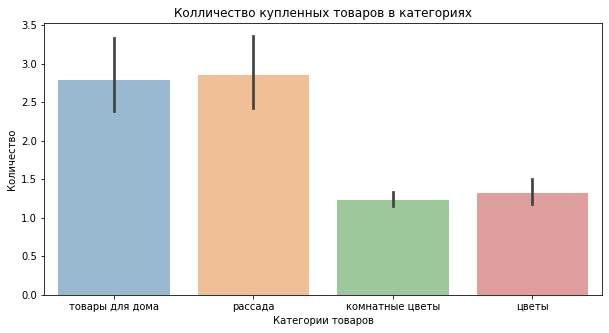

In [72]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='segment', y='quantity',
                 data=data,
                 alpha=0.5)
plt.title('Колличество купленных товаров в категориях')
plt.xlabel('Категории товаров')
plt.ylabel('Количество')

Сгруппируем датафрейм по покупательским категориям и посчитаем какие сегменты товаров пользуются у потребительских групп наибольшим спросом

In [73]:
clients_cats_data = clients_cats.merge(top_items, on=['customer_id'], how='inner')
clients_cats_data.head(5)

,customer_id,order_id,revenue,quantity_x,arpu,price_segment,cluster,product,quantity_y,segment
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,555.0,4,555.0,средний,1,Пеларгония зональная диам. 12 см темнорозовая полумахровая,1,цветы
1,000d6849-084e-4d9f-ac03-37174eaf60c4,1,555.0,4,555.0,средний,3,Пеларгония розебудная Rosebud Red d-7 см,1,комнатные цветы
2,000d6849-084e-4d9f-ac03-37174eaf60c4,1,555.0,4,555.0,средний,4,Пеларгония тюльпановидная EMMA,1,товары для дома
3,000d6849-084e-4d9f-ac03-37174eaf60c4,1,555.0,4,555.0,средний,3,Пеларгония розебудная Queen Ingrid укорененный черенок,1,комнатные цветы
4,001cee7f-0b29-4716-b202-0042213ab038,1,442.0,1,442.0,средний,2,Сушилка для белья потолочная ЛИАНА ЛЮКС 150 см ЛЛП-150,1,рассада


In [74]:
clients_cats_data = (clients_cats_data.groupby('price_segment')
                     .agg({'segment':'value_counts'})
                     .rename(columns={'segment':'count'}))
clients_cats_data

count
price_segment segment               
высокий       товары для дома    114
              рассада             61
              цветы                1
низкий        товары для дома     46
              рассада             38
средний       товары для дома   2004
              рассада           1639
              комнатные цветы    372
              цветы              266

# 2.4. Сезонность внутри группы

In [75]:
segment1 = clients_cats[clients_cats['price_segment']=='средний']
segment2 = clients_cats[clients_cats['price_segment']=='высокий']
segment3 = clients_cats[clients_cats['price_segment']=='низкий']

data_segment1 = data[data['customer_id'].isin(segment1['customer_id'])]
data_segment2 = data[data['customer_id'].isin(segment2['customer_id'])]
data_segment3= data[data['customer_id'].isin(segment3['customer_id'])]

In [76]:
x1 = data_segment1.groupby('month').order_id.nunique()
x2 = data_segment2.groupby('month').order_id.nunique()
x3 = data_segment3.groupby('month').order_id.nunique()

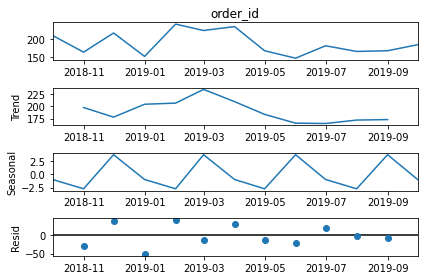

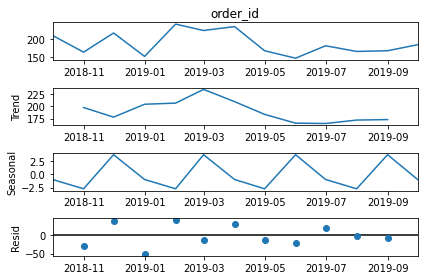

In [77]:
decomposition = seasonal_decompose(x1, period=3)
decomposition.plot()

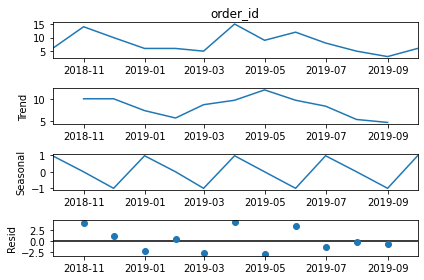

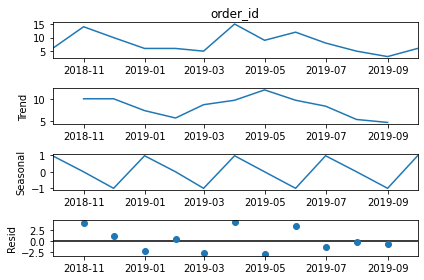

In [78]:
decomposition = seasonal_decompose(x2, period=3)
decomposition.plot()

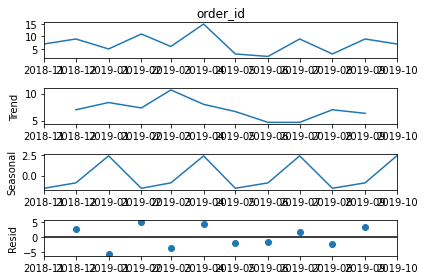

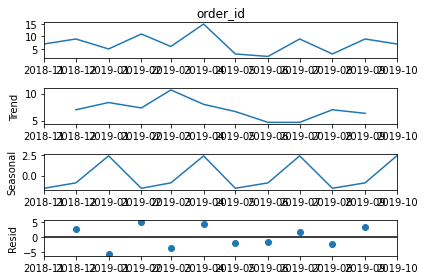

In [79]:
decomposition = seasonal_decompose(x3, period=3)
decomposition.plot()

Во всех 3-х группах присутствует квартальная сезонность

In [80]:
data_segment1.groupby('segment').customer_id.nunique()

segment
комнатные цветы     188
рассада            1212
товары для дома    1001
цветы                97
Name: customer_id, dtype: int64

In [81]:
data_segment2.groupby('segment').customer_id.nunique()

segment
рассада            37
товары для дома    54
цветы               1
Name: customer_id, dtype: int64

In [82]:
data_segment3.groupby('segment').customer_id.nunique()

segment
рассада            36
товары для дома    46
Name: customer_id, dtype: int64

# 2.5. А\Б тест

In [83]:
user_segment1 = data_segment1.groupby('customer_id', as_index=False).agg({'revenue':'sum','order_id':'nunique',
                                                                         'product':'nunique'})
user_segment2 = data_segment2.groupby('customer_id', as_index=False).agg({'revenue':'sum','order_id':'nunique',
                                                                         'product':'nunique'})
user_segment3 = data_segment3.groupby('customer_id', as_index=False).agg({'revenue':'sum','order_id':'nunique',
                                                                         'product':'nunique'})

In [84]:
user_segment1['arpu'] = user_segment1['revenue'] / user_segment1['order_id']
user_segment2['arpu'] = user_segment2['revenue'] / user_segment2['order_id']
user_segment3['arpu'] = user_segment1['revenue'] / user_segment3['order_id']

In [85]:
def test(data1,data2, column, alpha):

    results = st.mannwhitneyu(data1[column],
                          data2[column])

    print('p-значение:', results.pvalue)

    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

Сформулируем гипозизу $H_0$: \
***Средний чек пользователей «высокого» и «среднего» сегмента одинаков***\
Альтернативна гипотеза $H_1$: \
***Средний чек пользователей «высокого» и «среднего» сегмента различается.*** 


In [86]:
test(user_segment1, user_segment2, 'arpu', 0.01)

p-значение: 6.071581574073545e-56
Отвергаем нулевую гипотезу


Сформулируем гипозизу $H_0$: \
***Средний чек пользователей «высокого» и «низкий» сегмента одинаков***\
Альтернативна гипотеза $H_1$: \
***Средний чек пользователей «высокого» и «низкий» сегмента различается.*** 

In [87]:
test(user_segment2, user_segment3, 'arpu', 0.01)

p-значение: 1.3715714470963816e-28
Отвергаем нулевую гипотезу


Сформулируем гипозизу $H_0$: \
***Средний чек пользователей «средний» и «низкий» сегмента одинаков***\
Альтернативна гипотеза $H_1$: \
***Средний чек пользователей «средний» и «низкий» сегмента различается.*** 

In [88]:
test(user_segment1, user_segment3, 'arpu', 0.01)

p-значение: 0.09959441392543854
Не получилось отвергнуть нулевую гипотезу


Сформулируем гипозизу $H_0$: \
***Количество товаров в заказе клиентов из «высокого» и «среднего» сегмента равны.***\
Альтернативна гипотеза $H_1$: \
***Количество товаров в заказе клиентов из «высокого» и «среднего» сегмента не равны.*** 

In [89]:
test(user_segment1, user_segment2, 'product', 0.01)

p-значение: 0.9932221348224058
Не получилось отвергнуть нулевую гипотезу


Сформулируем гипозизу $H_0$: \
***Количество товаров в заказе клиентов из «высокого» и «низкого» сегмента равны.***\
Альтернативна гипотеза $H_1$: \
***Количество товаров в заказе клиентов из «высокого» и «низкого» сегмента не равны.*** 

In [90]:
test(user_segment2, user_segment3, 'product', 0.01)

p-значение: 0.0006129618415278917
Отвергаем нулевую гипотезу


In [91]:
test(user_segment1, user_segment3, 'product', 0.01)

p-значение: 0.00015514570130793353
Отвергаем нулевую гипотезу


# Вывод

Исходные данные содержат информацию о покупках пользователей за последние несколько лет. При детальном анализе было определено, что большинство пользователей совершают не более 1 покупки, причем кол-во товаров в чеке в среднем не превышает 6. В данных были обнаружены выбросы: кол-во покупок одного товара было больше 99% доверительного интервала и среди всех пользователей был найден один, который совершил более 100 покупок. Эти данные были успешно обработаны и выбросы были убраны. На основе среднего чека была проведена категоризация пользователей на 3 группы. По резльтатам А\Б теста только у среднего и низкого сегмента средний чек не отличается. Проведена проверка на наличие сезонной составляющей. Выяснилось, что во всех 3-х группах присутствует квартальная сезонность. На основе названий товаров была проведена сегментация покупательской корзины. В нее вошли такие сегменты, как все для дома, декоративные вещи, рассада, рассада цветы. На основе проведенного анализа данных можем рекомендовать интернет магазину создавать e-mail рассылку в середине каждого месяца. Наиболее популярным товаром для всех категорий являются товары для дома.

Рекомендации по сегментам:
1. Основную выручку приносят пользователи среднего сегмента. Имеет смысл делать упор на них и повышать их средний чек. Как пример - добавить рекомендательную систему
2. Низкий сегмент самый маленький. Судя по среднему чеку, покупатели берут семена и не больше. Возможно, данный сегмент имеет смысл убрать введя минимальный порог заказа, чтобы окупались затраты на 1 заказ
3. У высокого сегмента самый большой средний чек, однако кол-во заказов не высокое. Возможно, требуется сделать для них систему лояльности. Так, у нас немного просядет средний чек, но увеличится кол-во заказов
4. У категорий товаров также присутствует сезонность, для категории рассада наиболее популярными месяцами являются - Январь, Февраль и Март.

Пользователи среднего сегмента предпочитают покупать товары из рассады и товаров для дома, однако и из других сгементов тоже совершают покупки. Пользователи высокого сегменета покупают в основном товары для дома и рассаду (скорее всего это связано с выращиванием растерий в квартире). Пользователи низкого сегмента так же покупают только рассаду для дома.